In [1]:
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
from sklearn.metrics import r2_score

import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, KFold

from yellowbrick.regressor import prediction_error
from yellowbrick.regressor import residuals_plot

# Feature selection

## sku_with_big_discount_perc 

In [2]:
sku_with_big_discount_perc = pd.read_csv("sku_with_big_discount_perc.csv")

column ‘if_big_discount’: percentage of transactions where that sku had a discount > 50%

column ‘discount’: average discount across all transactions for the sku

### Check for outliers

In [3]:
sku_with_big_discount_perc[sku_with_big_discount_perc['discount']== -float("inf")]

,sku,classid,dept,upc,style,color,size,packsize,vendor,brand,if_big_discount,discount
0,3,6505,113,400000003000,00 F55KT2,WHISPERWHITE,P8EA,1,5119207,TURNBURY,0.5,-inf
1332,54044,8305,238,400004044005,EK Y90220,125WHITE/N,M,1,226176,DAX CORP,0.0,-inf
1587,62486,4505,109,400002486006,0ALD 096584,BLUE/WHITE,1655,1,5715232,POLO FAS,0.0,-inf
1643,66504,6006,214,400006504006,7 316NA1,PINK PUNCH,100M,1,60904,BROWN SH,0.0,-inf
1766,68698,4801,004,400008698006,335126,FUCHSIA,12,1,8716179,ALBERTO,0.0,-inf
...,...,...,...,...,...,...,...,...,...,...,...,...
263094,9887878,6601,006,400007878988,29D208,BLUEBERRY,6,1,8213318,FRANKIE,0.0,-inf
263992,9918533,3701,454,400008533991,L 214973,PINK/GREY,20,1,5016174,DANNY &,0.0,-inf
264442,9937565,1107,832,400007565993,SEPLATGLENRO,4294-405,SALAD,1,8014780,NORITAKE,0.0,-inf
265055,9959492,6006,312,400009492995,A101 CECELI,NAT,075M,1,8016880,UNISA AM,0.0,-inf


In [4]:
sku_with_big_discount_perc[sku_with_big_discount_perc['discount']== float("inf")]

,sku,classid,dept,upc,style,color,size,packsize,vendor,brand,if_big_discount,discount


### Drop the rows with discount = -inf

In [5]:
sku_with_big_discount_perc.shape

(266225, 12)

Since 495 is small compared to 266225, we can drop the rows with discount = -inf.

In [6]:
sku_with_big_discount_perc_cleaned = sku_with_big_discount_perc[sku_with_big_discount_perc['discount'] != -float("inf")]

In [7]:
sku_with_big_discount_perc_cleaned

,sku,classid,dept,upc,style,color,size,packsize,vendor,brand,if_big_discount,discount
1,78,5301,001,400000078000,70091L440400,BROWN,10,1,9912767,M.M. & R,0.00,0.000000
2,156,8101,302,400000156000,E16 F4088B,PINK/WHITE,L,1,814935,FU DA IN,0.00,0.000000
3,180,1704,104,400000180000,42 BE0200,WYEL,9 MONTHS,1,3213321,RALPH LA,0.00,0.000000
4,268,8101,006,400000268000,120198311332,BROWN,14,1,916212,JERELL /,0.00,0.000000
5,387,9306,913,400000387000,74017,BROWN,110M,1,5016699,TIMBERLA,0.00,0.006000
...,...,...,...,...,...,...,...,...,...,...,...,...
266220,9999926,3701,154,400009926999,4W 852335,BLACK MULT,20,1,2015532,DONNA RI,0.00,0.000000
266221,9999933,3404,001,400009933999,01DL B8315C,FUCHSIA,4,1,1016208,SWAT FAM,0.25,0.174450
266222,9999950,800,007,400009950999,635P,10BERRY,LL SHINE,3,5511283,CLINIQUE,0.00,0.000131
266223,9999956,7101,004,400009956999,82 EJMU43,CL NAVY,18,1,3313116,EMMA JAM,0.00,0.000000


In [8]:
len(np.unique(sku_with_big_discount_perc_cleaned['size']))

3353

We 3353 types in the original size column. We can reduce the number of types by grouping the numerical size values together.

### Clean the numeric size

In [9]:
sku_with_big_discount_perc_cleaned = sku_with_big_discount_perc_cleaned[sku_with_big_discount_perc_cleaned['size'].str.extract(r'([\d])')[0] != np.nan]

In [10]:
import re
sku_with_big_discount_perc_cleaned['cleaned_size'] = sku_with_big_discount_perc_cleaned['size'].apply(lambda x:int("".join(re.findall(r'([\d])',x))) if "".join(re.findall(r'([\d])',x)) != "" else x)

In [11]:
temp = sku_with_big_discount_perc_cleaned.loc[sku_with_big_discount_perc_cleaned['cleaned_size'].apply(lambda x:isinstance(x, int))]
temp.sort_values(by='cleaned_size') 

,sku,classid,dept,upc,style,color,size,packsize,vendor,brand,if_big_discount,discount,cleaned_size
103753,3857487,3103,007,400007487385,015 017016,LT BLUE 9,0,1,6076489,LEVI STR,0.000000,0.207126,0
263415,9898004,3103,006,400008004989,556 115185,MD BLUE S,0,1,6076489,LEVI STR,0.000000,0.128086,0
21330,806055,3103,005,400006055080,21 KXRU64,MIDNITWSH,0 ND,1,5511254,LIZ CLAI,1.000000,0.759025,0
197835,7416841,3103,006,400006841741,19 KXRU67,DKBLST TNT,0,1,5511254,LIZ CLAI,0.333333,0.357401,0
21378,807275,4303,006,400007275080,KU4160,GRY MULTI,0,1,6713313,ESPRIT U,1.000000,0.915424,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
112341,4178451,5100,007,400008451417,168038,ANGEL ROSE,168038,3,6041161,CHANEL I,0.000000,0.000000,168038
245992,9237103,2200,006,400007103923,2137,04-SABLE,2137-04,3,113645,LANCOME,0.000000,0.000153,213704
246228,9247103,2200,006,400007103924,2137,05-CHATAIGE,2137-05,3,113645,LANCOME,0.000000,0.000361,213705
41675,1583514,2200,006,400003514158,2137,08-NATURAL,2137-08,3,113645,LANCOME,0.000000,0.000087,213708


In [12]:
temp[temp['cleaned_size'] > 50]

,sku,classid,dept,upc,style,color,size,packsize,vendor,brand,if_big_discount,discount,cleaned_size
5,387,9306,913,400000387000,74017,BROWN,110M,1,5016699,TIMBERLA,0.000000,0.006000,110
18,1634,7106,214,400001634000,BLKMPTLIBRTY,BLK MULT P,070M,1,5010255,ENZO ANG,0.000000,0.027895,70
23,3085,5305,453,400003085000,94 MERU16,STONE,38 29,1,5531254,LIZ CLAI,1.000000,0.500000,3829
24,3392,9105,917,400003392000,891 015504,STONEWASH,48 30,1,6416489,LEVI STR,0.000000,0.007674,4830
26,3653,5305,453,400003653000,95 MERU20,KHAKI,31 32,1,5531254,LIZ CLAI,1.000000,0.701642,3132
...,...,...,...,...,...,...,...,...,...,...,...,...,...
266121,9998187,8104,301,400008187999,27 DD6BQ1,ORANGE,12.5,1,7212685,GRAND KN,0.000000,0.166750,125
266126,9998241,8306,223,400008241999,4 JF1250,AQUA,125M,1,4023396,KEDS COR,0.000000,0.044384,125
266141,9998384,8104,301,400008384999,LU A5135B,BLUE,12.5,1,1813316,IN MOCEA,0.333333,0.316825,125
266154,9998460,6006,211,400008460999,AVA242,BRONZE,085M,1,8016880,UNISA AM,0.000000,0.000000,85


Lots of numerical sizes contain information related to style and are formatted badly. The cleaning of numerical values seem a big challenge.

### Clean the other size

In [13]:
sku_with_big_discount_perc_cleaned['cleaned_size'] =  sku_with_big_discount_perc_cleaned['cleaned_size'].str.replace(" ", "")

In [14]:
sku_with_big_discount_perc_cleaned

,sku,classid,dept,upc,style,color,size,packsize,vendor,brand,if_big_discount,discount,cleaned_size
1,78,5301,001,400000078000,70091L440400,BROWN,10,1,9912767,M.M. & R,0.00,0.000000,NaN
2,156,8101,302,400000156000,E16 F4088B,PINK/WHITE,L,1,814935,FU DA IN,0.00,0.000000,L
3,180,1704,104,400000180000,42 BE0200,WYEL,9 MONTHS,1,3213321,RALPH LA,0.00,0.000000,NaN
4,268,8101,006,400000268000,120198311332,BROWN,14,1,916212,JERELL /,0.00,0.000000,NaN
5,387,9306,913,400000387000,74017,BROWN,110M,1,5016699,TIMBERLA,0.00,0.006000,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
266220,9999926,3701,154,400009926999,4W 852335,BLACK MULT,20,1,2015532,DONNA RI,0.00,0.000000,NaN
266221,9999933,3404,001,400009933999,01DL B8315C,FUCHSIA,4,1,1016208,SWAT FAM,0.25,0.174450,NaN
266222,9999950,800,007,400009950999,635P,10BERRY,LL SHINE,3,5511283,CLINIQUE,0.00,0.000131,LLSHINE
266223,9999956,7101,004,400009956999,82 EJMU43,CL NAVY,18,1,3313116,EMMA JAM,0.00,0.000000,NaN


In [15]:
sku_with_big_discount_perc_cleaned['size_text_or_not'] = sku_with_big_discount_perc_cleaned['cleaned_size'].apply(lambda x: not str(x).isnumeric())

In [16]:
sku_with_big_discount_perc_cleaned

,sku,classid,dept,upc,style,color,size,packsize,vendor,brand,if_big_discount,discount,cleaned_size,size_text_or_not
1,78,5301,001,400000078000,70091L440400,BROWN,10,1,9912767,M.M. & R,0.00,0.000000,NaN,True
2,156,8101,302,400000156000,E16 F4088B,PINK/WHITE,L,1,814935,FU DA IN,0.00,0.000000,L,True
3,180,1704,104,400000180000,42 BE0200,WYEL,9 MONTHS,1,3213321,RALPH LA,0.00,0.000000,NaN,True
4,268,8101,006,400000268000,120198311332,BROWN,14,1,916212,JERELL /,0.00,0.000000,NaN,True
5,387,9306,913,400000387000,74017,BROWN,110M,1,5016699,TIMBERLA,0.00,0.006000,NaN,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
266220,9999926,3701,154,400009926999,4W 852335,BLACK MULT,20,1,2015532,DONNA RI,0.00,0.000000,NaN,True
266221,9999933,3404,001,400009933999,01DL B8315C,FUCHSIA,4,1,1016208,SWAT FAM,0.25,0.174450,NaN,True
266222,9999950,800,007,400009950999,635P,10BERRY,LL SHINE,3,5511283,CLINIQUE,0.00,0.000131,LLSHINE,True
266223,9999956,7101,004,400009956999,82 EJMU43,CL NAVY,18,1,3313116,EMMA JAM,0.00,0.000000,NaN,True


In [17]:
sku_with_big_discount_perc_cleaned.shape

(265730, 14)

In [18]:
sku_with_big_discount_perc_cleaned_nonnum = sku_with_big_discount_perc_cleaned[sku_with_big_discount_perc_cleaned['size_text_or_not'] == True]

In [19]:
sku_with_big_discount_perc_cleaned_nonnum['cleaned_size'] = sku_with_big_discount_perc_cleaned_nonnum['cleaned_size'].str.replace(" ","")#sku_with_big_discount_perc_cleaned_nonnum['cleand_size'].apply(lambda x:x.replace(" ", ""))

In [20]:
sku_with_big_discount_perc_cleaned_nonnum['cleaned_size'][2]

'L'

There're 132785 out of 265730 rows of item with non-numerical size.

In [21]:
sku_with_big_discount_perc_cleaned_nonnum[sku_with_big_discount_perc_cleaned_nonnum['cleaned_size'].isin(["XS","S","M","L","XL", "ALL", "ONE"])] 

,sku,classid,dept,upc,style,color,size,packsize,vendor,brand,if_big_discount,discount,cleaned_size,size_text_or_not
2,156,8101,302,400000156000,E16 F4088B,PINK/WHITE,L,1,814935,FU DA IN,0.000000,0.000000,L,True
7,561,5203,002,400000561000,UK 36044J,CHOCO,XL,1,8016212,MOA MOA,0.000000,0.000000,XL,True
8,629,5203,002,400000629000,49 A18640,BLACK,M,1,4916175,COMPLETE,0.000000,0.000000,M,True
11,879,5404,005,400000879000,1B RL4AF2,BLACK,XL,1,7613115,GIANT ME,0.000000,0.000000,XL,True
13,1087,2301,002,400001087000,1 5411M2,BLACK,M,1,7516185,AGB,0.000000,0.000000,M,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
266209,9999707,4303,002,400009707999,96 IDT704,150IVORY/P,M,1,13116,HEART AN,0.272727,0.136364,M,True
266212,9999777,3404,00A,400009777999,8 JA3206,678FIESTA PI,M,1,9516211,DESIGNER,1.000000,0.500000,M,True
266214,9999802,6505,113,400009802999,10 F55KR7,BLACK CHERRY,XL,1,5119207,ROUNDTRE,0.000000,0.000000,XL,True
266218,9999901,2301,002,400009901999,7 5452X2,SAND,M,1,7516185,AGB,0.000000,0.000000,M,True


For non-numerical size ("XS","S","M","L","XL", "ALL", "ONE"), there're 113,690 out of 132,785 items.

**We could use sku_with_big_discount_perc_cleaned_nonumsize as our samples to train the models.**

In [22]:
sku_with_big_discount_perc_cleaned_finalSize = sku_with_big_discount_perc_cleaned_nonnum[sku_with_big_discount_perc_cleaned_nonnum['cleaned_size'].isin(["XS","S","M","L","XL", "ALL", "ONE"])] 

In [23]:
sku_with_big_discount_perc_cleaned_finalSize

,sku,classid,dept,upc,style,color,size,packsize,vendor,brand,if_big_discount,discount,cleaned_size,size_text_or_not
2,156,8101,302,400000156000,E16 F4088B,PINK/WHITE,L,1,814935,FU DA IN,0.000000,0.000000,L,True
7,561,5203,002,400000561000,UK 36044J,CHOCO,XL,1,8016212,MOA MOA,0.000000,0.000000,XL,True
8,629,5203,002,400000629000,49 A18640,BLACK,M,1,4916175,COMPLETE,0.000000,0.000000,M,True
11,879,5404,005,400000879000,1B RL4AF2,BLACK,XL,1,7613115,GIANT ME,0.000000,0.000000,XL,True
13,1087,2301,002,400001087000,1 5411M2,BLACK,M,1,7516185,AGB,0.000000,0.000000,M,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
266209,9999707,4303,002,400009707999,96 IDT704,150IVORY/P,M,1,13116,HEART AN,0.272727,0.136364,M,True
266212,9999777,3404,00A,400009777999,8 JA3206,678FIESTA PI,M,1,9516211,DESIGNER,1.000000,0.500000,M,True
266214,9999802,6505,113,400009802999,10 F55KR7,BLACK CHERRY,XL,1,5119207,ROUNDTRE,0.000000,0.000000,XL,True
266218,9999901,2301,002,400009901999,7 5452X2,SAND,M,1,7516185,AGB,0.000000,0.000000,M,True


In [24]:
sku_with_big_discount_perc_cleaned_finalSize.groupby('cleaned_size').count()

,sku,classid,dept,upc,style,color,size,packsize,vendor,brand,if_big_discount,discount,size_text_or_not
cleaned_size,,,,,,,,,,,,,
ALL,28153,28153,28153,28153,28153,28153,28153,28153,28153,28153,28153,28011,28153
L,23708,23708,23708,23708,23708,23708,23708,23708,23708,23708,23708,23629,23708
M,23624,23624,23624,23624,23624,23624,23624,23624,23624,23624,23624,23554,23624
ONE,2349,2349,2349,2349,2349,2349,2349,2349,2349,2349,2349,2335,2349
S,18070,18070,18070,18070,18070,18070,18070,18070,18070,18070,18070,18024,18070
XL,17282,17282,17282,17282,17282,17282,17282,17282,17282,17282,17282,17248,17282
XS,504,504,504,504,504,504,504,504,504,504,504,504,504


### Clean the color

In [25]:
len(sku_with_big_discount_perc_cleaned_finalSize['color'].unique())

10810

Before cleaning the color category, we have 10810 types of colors.

In [26]:
# importing necessary libraries
import pandas as pd
import numpy as np
# !pip install kmodes
from kmodes.kmodes import KModes
import matplotlib.pyplot as plt
%matplotlib inline

**Drop the NaN values in the data.**

In [27]:
sku_with_big_discount_perc_cleaned_finalSize = sku_with_big_discount_perc_cleaned_finalSize.dropna()

**Create a color dictionary for types of color.**

In [28]:
color_map = ['BLACK', 'WHITE', 'RED', 'GREEN', 'YELLOW', 'BLUE', 'BROWN', 'ORANGE', 'PINK', 'PURPLE', 'GREY']

In [29]:
sku_with_big_discount_perc_cleaned_finalSize['color'] = sku_with_big_discount_perc_cleaned_finalSize['color'].str.replace(" ",'')

<ipython-input-29-c9b9acf894b8>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sku_with_big_discount_perc_cleaned_finalSize['color'] = sku_with_big_discount_perc_cleaned_finalSize['color'].str.replace(" ",'')


In [30]:
sku_with_big_discount_perc_cleaned_finalSize.shape

(113305, 14)

In [31]:
sku_with_big_discount_perc_cleaned_finalSize['cleaned_size'].value_counts()

ALL    28011
L      23629
M      23554
S      18024
XL     17248
ONE     2335
XS       504
Name: cleaned_size, dtype: int64

In [32]:
#sku_with_big_discount_perc_cleaned_finalSize.to_csv("sku_with_big_discount_perc_cleaned_finalSize.csv")

**Drop all the numerical values in the color.**

In [33]:
sku_with_big_discount_perc_cleaned_finalSize['color']

2          PINK/WHITE
7               CHOCO
8               BLACK
11              BLACK
13              BLACK
             ...     
266209     150IVORY/P
266212    678FIESTAPI
266214    BLACKCHERRY
266218           SAND
266219         BSWEET
Name: color, Length: 113305, dtype: object

In [34]:
sku_with_big_discount_perc_cleaned_finalSize[sku_with_big_discount_perc_cleaned_finalSize['color'].isin(color_map)]





,sku,classid,dept,upc,style,color,size,packsize,vendor,brand,if_big_discount,discount,cleaned_size,size_text_or_not
8,629,5203,002,400000629000,49 A18640,BLACK,M,1,4916175,COMPLETE,0.000000,0.000000,M,True
11,879,5404,005,400000879000,1B RL4AF2,BLACK,XL,1,7613115,GIANT ME,0.000000,0.000000,XL,True
13,1087,2301,002,400001087000,1 5411M2,BLACK,M,1,7516185,AGB,0.000000,0.000000,M,True
21,3018,5102,502,400003018000,128237,PINK,ALL,1,1411309,COLLECTI,1.000000,0.515500,ALL,True
33,3881,1905,315,400003881000,14 S45QM5,BLACK,ALL,1,66561,MURANO I,0.400000,0.200000,ALL,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
266184,9999094,9801,004,400009094999,767177,BLACK,S,1,135348,QUIKSILV,1.000000,0.500000,S,True
266185,9999157,5102,009,400009157999,5KZTDG,GREY,ALL,1,4714937,ALL PRO,0.500000,0.350000,ALL,True
266187,9999177,9801,113,400009177999,36335,RED,M,1,7650476,BAREFOOT,0.000000,0.250000,M,True
266190,9999235,2503,211,400009235999,1D 3450AH,WHITE,S,1,14636,MY MICHE,0.038462,0.130385,S,True


In [35]:
sku_with_big_discount_perc_cleaned_finalSize[sku_with_big_discount_perc_cleaned_finalSize['color'].str.contains("BLAC")]

,sku,classid,dept,upc,style,color,size,packsize,vendor,brand,if_big_discount,discount,cleaned_size,size_text_or_not
8,629,5203,002,400000629000,49 A18640,BLACK,M,1,4916175,COMPLETE,0.000,0.000000,M,True
11,879,5404,005,400000879000,1B RL4AF2,BLACK,XL,1,7613115,GIANT ME,0.000,0.000000,XL,True
13,1087,2301,002,400001087000,1 5411M2,BLACK,M,1,7516185,AGB,0.000,0.000000,M,True
33,3881,1905,315,400003881000,14 S45QM5,BLACK,ALL,1,66561,MURANO I,0.400,0.200000,ALL,True
34,3882,1905,535,400003882000,34 S45QR5,BLACK,ALL,1,212785,ROUNDTRE,0.625,0.381250,ALL,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
266098,9997829,6404,206,400007829999,N AL156-,BLACK,XL,1,6916221,NOW AND,0.800,0.496536,XL,True
266135,9998328,2503,301,400008328999,15911T,BLACK,L,1,8011235,CHOON IN,1.000,0.500000,L,True
266162,9998516,5203,006,400008516999,00 HB0281,BLACK,S,1,5613314,JUNK FOO,0.500,0.291875,S,True
266184,9999094,9801,004,400009094999,767177,BLACK,S,1,135348,QUIKSILV,1.000,0.500000,S,True


In [36]:
sku_with_big_discount_perc_cleaned_finalSize

,sku,classid,dept,upc,style,color,size,packsize,vendor,brand,if_big_discount,discount,cleaned_size,size_text_or_not
2,156,8101,302,400000156000,E16 F4088B,PINK/WHITE,L,1,814935,FU DA IN,0.000000,0.000000,L,True
7,561,5203,002,400000561000,UK 36044J,CHOCO,XL,1,8016212,MOA MOA,0.000000,0.000000,XL,True
8,629,5203,002,400000629000,49 A18640,BLACK,M,1,4916175,COMPLETE,0.000000,0.000000,M,True
11,879,5404,005,400000879000,1B RL4AF2,BLACK,XL,1,7613115,GIANT ME,0.000000,0.000000,XL,True
13,1087,2301,002,400001087000,1 5411M2,BLACK,M,1,7516185,AGB,0.000000,0.000000,M,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
266209,9999707,4303,002,400009707999,96 IDT704,150IVORY/P,M,1,13116,HEART AN,0.272727,0.136364,M,True
266212,9999777,3404,00A,400009777999,8 JA3206,678FIESTAPI,M,1,9516211,DESIGNER,1.000000,0.500000,M,True
266214,9999802,6505,113,400009802999,10 F55KR7,BLACKCHERRY,XL,1,5119207,ROUNDTRE,0.000000,0.000000,XL,True
266218,9999901,2301,002,400009901999,7 5452X2,SAND,M,1,7516185,AGB,0.000000,0.000000,M,True


In [37]:
color_df = pd.DataFrame(sku_with_big_discount_perc_cleaned_finalSize['color'].value_counts())

In [38]:
color_df = color_df.reset_index()

In [39]:
color_df

,index,color
0,BLACK,7864
1,WHITE,4426
2,RED,2376
3,PINK,2359
4,MULTI,2034
...,...,...
10669,BLAC/FUSHI,1
10670,SNO,1
10671,WHITE/SKY,1
10672,CLNWHITE,1


In [40]:
color_df[color_df['index'].str.contains('BLAC')] 

,index,color
0,BLACK,7864
9,001BLACK,1106
33,BLACKNESS,296
51,RLBLACK,208
57,BLACK/WHIT,175
...,...,...
10534,ROYAL/BLACK,1
10551,BLACK/ORANGE,1
10584,BLACK/WALNUT,1
10615,002PMBLAC,1


### Cleaned size and color data

In [41]:
sku_with_big_discount_perc_cleaned_colorSize = pd.read_csv("data_new_color.csv")

In [42]:
sku_with_big_discount_perc_cleaned_colorSize




,Unnamed: 0,sku,classid,dept,upc,style,color,size,packsize,vendor,brand,if_big_discount,discount,cleaned_size,size_num_or_not,new_color
0,2,156,8101,302,400000156000,E16 F4088B,PINK/WHITE,L,1,814935,FU DA IN,0.000000,0.000000,L,True,PINK
1,7,561,5203,002,400000561000,UK 36044J,CHOCO,XL,1,8016212,MOA MOA,0.000000,0.000000,XL,True,other
2,8,629,5203,002,400000629000,49 A18640,BLACK,M,1,4916175,COMPLETE,0.000000,0.000000,M,True,BLACK
3,11,879,5404,005,400000879000,1B RL4AF2,BLACK,XL,1,7613115,GIANT ME,0.000000,0.000000,XL,True,BLACK
4,13,1087,2301,002,400001087000,1 5411M2,BLACK,M,1,7516185,AGB,0.000000,0.000000,M,True,BLACK
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113024,266209,9999707,4303,002,400009707999,96 IDT704,150IVORY/P,M,1,13116,HEART AN,0.272727,0.136364,M,True,other
113025,266212,9999777,3404,00A,400009777999,8 JA3206,678FIESTAPI,M,1,9516211,DESIGNER,1.000000,0.500000,M,True,other
113026,266214,9999802,6505,113,400009802999,10 F55KR7,BLACKCHERRY,XL,1,5119207,ROUNDTRE,0.000000,0.000000,XL,True,BLACK
113027,266218,9999901,2301,002,400009901999,7 5452X2,SAND,M,1,7516185,AGB,0.000000,0.000000,M,True,other


In [101]:
#sku_with_big_discount_perc_cleaned_colorSize.to_csv("sku_with_big_discount_perc_cleaned_colorSize_with_preds.csv")

In [43]:
cleaned_data_big_discount = sku_with_big_discount_perc_cleaned_colorSize.drop(columns = ["color", "size", "sku","size_num_or_not", 'Unnamed: 0', 'style', 'packsize', 'brand', 'size_num_or_not', 'upc','discount'])

In [44]:
cleaned_data = sku_with_big_discount_perc_cleaned_colorSize.drop(columns = ["color", "size", "sku","size_num_or_not", 'Unnamed: 0', 'style', 'packsize', 'brand', 'size_num_or_not', 'upc','if_big_discount'])

In [45]:
cleaned_data['cleaned_size'].value_counts()

ALL    27904
L      23627
M      23551
S      18022
XL     17247
ONE     2174
XS       504
Name: cleaned_size, dtype: int64

In [46]:
cleaned_data['new_color'].value_counts()

other      62416
BLACK      14013
BLUE        8494
WHITE       7025
PINK        4887
RED         4345
MULTI       2810
SILVER      2042
GREEN       1949
NOCOLOR     1389
GOLD        1378
BROWN       1212
YELLOW      1069
Name: new_color, dtype: int64

In [47]:
cleaned_data

,classid,dept,vendor,discount,cleaned_size,new_color
0,8101,302,814935,0.000000,L,PINK
1,5203,002,8016212,0.000000,XL,other
2,5203,002,4916175,0.000000,M,BLACK
3,5404,005,7613115,0.000000,XL,BLACK
4,2301,002,7516185,0.000000,M,BLACK
...,...,...,...,...,...,...
113024,4303,002,13116,0.136364,M,other
113025,3404,00A,9516211,0.500000,M,other
113026,6505,113,5119207,0.000000,XL,BLACK
113027,2301,002,7516185,0.000000,M,other


## one-hot encoding

In [48]:
from numpy import array
from numpy import argmax
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

In [49]:
# integer encode
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(cleaned_data['cleaned_size'])
print(integer_encoded)
# binary encode
onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
print(onehot_encoded)

[1 5 2 ... 5 2 2]
[[0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]]


In [50]:
one_hot_size = pd.DataFrame(onehot_encoded, columns = ['ALL', 'L','M','ONE', 'S', 'XL', 'XS'])

In [51]:
one_hot_size

,ALL,L,M,ONE,S,XL,XS
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...
113024,0.0,0.0,1.0,0.0,0.0,0.0,0.0
113025,0.0,0.0,1.0,0.0,0.0,0.0,0.0
113026,0.0,0.0,0.0,0.0,0.0,1.0,0.0
113027,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [52]:
# integer encode
label_encoder_color = LabelEncoder()
integer_encoded_color = label_encoder_color.fit_transform(cleaned_data['new_color'])
print(integer_encoded_color)
# binary encode
onehot_encoder_color = OneHotEncoder(sparse=False)
integer_encoded_color = integer_encoded_color.reshape(len(integer_encoded_color), 1)
onehot_encoded_color = onehot_encoder_color.fit_transform(integer_encoded_color)
print(onehot_encoded_color)

[ 7 12  0 ...  0 12 12]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]


In [53]:
one_hot_color = pd.DataFrame(onehot_encoded_color, columns = ['BLACK', 'BLUE','BROWN','GOLD', 'GREEN', 
                                                        'MULTI', 'NOCOLOR', 'PINK', 'RED', 'SILVER', 
                                                        'WHITE', 'YELLOW', 'other'])

In [54]:
one_hot_color

,BLACK,BLUE,BROWN,GOLD,GREEN,MULTI,NOCOLOR,PINK,RED,SILVER,WHITE,YELLOW,other
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
113024,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
113025,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
113026,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
113027,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [55]:
one_hot_color['other'].value_counts()

1.0    62416
0.0    50613
Name: other, dtype: int64

In [56]:
pd.to_numeric(cleaned_data['dept'], errors='coerce').fillna(-1)

0         302.0
1           2.0
2           2.0
3           5.0
4           2.0
          ...  
113024      2.0
113025     -1.0
113026    113.0
113027      2.0
113028      5.0
Name: dept, Length: 113029, dtype: float64

In [57]:
cleaned_data['dept_cleaned'] = pd.to_numeric(cleaned_data['dept'], errors='coerce').fillna(-1)

In [58]:
final_cleaned_data = pd.concat([cleaned_data,one_hot_size, one_hot_color], axis=1).drop(columns = ['cleaned_size', 'new_color', 'dept'])

In [59]:
final_cleaned_data.shape

(113029, 24)

In [60]:
len(final_cleaned_data['discount'].unique())

35189

In [61]:
final_cleaned_data[final_cleaned_data['discount']==0].shape

(23311, 24)

In [62]:
#final_cleaned_data.to_csv('final_cleaned_data.csv')

In [63]:
# One-hot encoding class_id
# integer encode
label_encoder_class = LabelEncoder()
integer_encoded_class = label_encoder_class.fit_transform(cleaned_data['classid'])
print(integer_encoded_class)
# binary encode
onehot_encoder_class = OneHotEncoder(sparse=False)
integer_encoded_class = integer_encoded_class.reshape(len(integer_encoded_class), 1)
onehot_encoded_class= onehot_encoder_class.fit_transform(integer_encoded_class)
print(onehot_encoded_class)


[42 24 24 ... 33  9 16]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [64]:
one_hot_class = pd.DataFrame(onehot_encoded_class)

In [65]:
final_cleaned_data = pd.concat([final_cleaned_data,one_hot_class], axis=1).drop(columns = ['classid'])

In [66]:
final_cleaned_data

,vendor,discount,dept_cleaned,ALL,L,M,ONE,S,XL,XS,...,40,41,42,43,44,45,46,47,48,49
0,814935,0.000000,302.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,8016212,0.000000,2.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,4916175,0.000000,2.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,7613115,0.000000,5.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,7516185,0.000000,2.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113024,13116,0.136364,2.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
113025,9516211,0.500000,-1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
113026,5119207,0.000000,113.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
113027,7516185,0.000000,2.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [67]:
# One-hot encoding vendor
# integer encode
label_encoder_vendor = LabelEncoder()
integer_encoded_vendor = label_encoder_vendor.fit_transform(cleaned_data['vendor'])
print(integer_encoded_vendor)
# binary encode
onehot_encoder_vendor = OneHotEncoder(sparse=False)
integer_encoded_vendor = integer_encoded_vendor.reshape(len(integer_encoded_vendor), 1)
onehot_encoded_vendor= onehot_encoder_vendor.fit_transform(integer_encoded_vendor)
print(onehot_encoded_vendor)


[112 747 457 ... 477 708 793]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [68]:
one_hot_vendor = pd.DataFrame(onehot_encoded_vendor)

In [69]:
final_cleaned_data = pd.concat([final_cleaned_data,one_hot_vendor], axis=1).drop(columns = ['vendor'])

In [70]:
final_cleaned_data

,discount,dept_cleaned,ALL,L,M,ONE,S,XL,XS,BLACK,...,900,901,902,903,904,905,906,907,908,909
0,0.000000,302.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.000000,2.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,2.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000000,5.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000000,2.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113024,0.136364,2.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
113025,0.500000,-1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
113026,0.000000,113.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
113027,0.000000,2.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [71]:
#final_cleaned_data.to_csv("final_cleaned_data_ohe.csv")

In [72]:


# integer encode
label_encoder_v2 = LabelEncoder()
integer_encoded_v2 = label_encoder_v2.fit_transform(cleaned_data_big_discount['cleaned_size'])
print(integer_encoded_v2)
# binary encode
onehot_encoder_v2 = OneHotEncoder(sparse=False)
integer_encoded_v2 = integer_encoded_v2.reshape(len(integer_encoded_v2), 1)
onehot_encoded_v2 = onehot_encoder_v2.fit_transform(integer_encoded_v2)
print(onehot_encoded_v2)

one_hot_size_v2 = pd.DataFrame(onehot_encoded_v2, columns = ['ALL', 'L','M','ONE', 'S', 'XL', 'XS'])

# integer encode
label_encoder_color_v2 = LabelEncoder()
integer_encoded_color_v2 = label_encoder_color_v2.fit_transform(cleaned_data_big_discount['new_color'])
print(integer_encoded_color_v2)
# binary encode
onehot_encoder_color_v2 = OneHotEncoder(sparse=False)
integer_encoded_color_v2 = integer_encoded_color_v2.reshape(len(integer_encoded_color_v2), 1)
onehot_encoded_color_v2 = onehot_encoder_color_v2.fit_transform(integer_encoded_color_v2)
print(onehot_encoded_color_v2)

one_hot_color_v2 = pd.DataFrame(onehot_encoded_color_v2, columns = ['BLACK', 'BLUE','BROWN','GOLD', 'GREEN', 
                                                        'MULTI', 'NOCOLOR', 'PINK', 'RED', 'SILVER', 
                                                        'WHITE', 'YELLOW', 'other'])


[1 5 2 ... 5 2 2]
[[0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]]
[ 7 12  0 ...  0 12 12]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]


In [73]:

cleaned_data_big_discount['dept_cleaned'] = pd.to_numeric(cleaned_data_big_discount['dept'], errors='coerce').fillna(-1)
final_cleaned_data_v2 = pd.concat([cleaned_data_big_discount,one_hot_size_v2, one_hot_color_v2], axis=1).drop(columns = ['cleaned_size', 'new_color', 'dept'])

In [74]:
final_cleaned_data.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113029 entries, 0 to 113028
Columns: 982 entries, discount to 909
dtypes: float64(982)
memory usage: 846.8 MB


In [75]:
X, y =  final_cleaned_data.loc[:, final_cleaned_data.columns!='discount'].values, final_cleaned_data.loc[:,'discount'].values

In [76]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [114]:
len(y_train) 

90423

In [113]:
len(y_test)

22606

## Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
logreg = LogisticRegression()

from sklearn import preprocessing
from sklearn import utils

#convert y values to categorical values
lab = preprocessing.LabelEncoder()
y_transformed_train = lab.fit_transform(y_train)

logreg.fit(X_train, y_transformed_train)

In [ ]:
predictions_train_lr = logreg.predict(X_train)
rmse = np.sqrt(mean_squared_error(y_transformed_train, predictions_train_lr))
print("RMSE: %f" % (rmse))

r2 = np.sqrt(r2_score(y_transformed_train, predictions_train_lr))
print("R_Squared Score : %f" % (r2))

In [ ]:
predictions_lr = logreg.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, predictions_lr))
print("RMSE: %f" % (rmse))

r2 = np.sqrt(r2_score(y_test, predictions_lr))
print("R_Squared Score : %f" % (r2))

## Train Decision Tree Model

In [115]:
from sklearn.tree import DecisionTreeRegressor
dt = DecisionTreeRegressor(random_state = 42)
# Train the model on training data
dt.fit(X_train, y_train);


In [116]:
predictions_train_dt = dt.predict(X_train)
rmse = np.sqrt(mean_squared_error(y_train, predictions_train_dt))
print("RMSE: %f" % (rmse))

r2 = np.sqrt(r2_score(y_train, predictions_train_dt))
print("R_Squared Score : %f" % (r2))

RMSE: 0.197684
R_Squared Score : 0.681214


In [117]:
predictions_dt = dt.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, predictions_dt))
print("RMSE: %f" % (rmse))

r2 = np.sqrt(r2_score(y_test, predictions_dt))
print("R_Squared Score : %f" % (r2))

RMSE: 0.258321
R_Squared Score : 0.285457


In [ ]:
# overfit

final_cleaned_data["prediction_discount_base"]= np.append(predictions_train_dt,predictions_dt)

In [ ]:
final_cleaned_data

In [ ]:
#final_cleaned_data.to_csv("final_cleaned_data_with_pred_base_final.csv")


## Train Random Forest Model

In [ ]:
# Import the model we are using
from sklearn.ensemble import RandomForestRegressor
# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 5, random_state = 42)
# Train the model on training data
rf.fit(X_train, y_train);

In [ ]:
predictions_train_rf = rf.predict(X_train)
rmse = np.sqrt(mean_squared_error(y_train, predictions_train_rf))
print("RMSE: %f" % (rmse))

r2 = np.sqrt(r2_score(y_train, predictions_train_rf))
print("R_Squared Score : %f" % (r2))

In [ ]:
predictions_rf = rf.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, predictions_rf))
print("RMSE: %f" % (rmse))

r2 = np.sqrt(r2_score(y_test, predictions_rf))
print("R_Squared Score : %f" % (r2))

In [ ]:
# Overfit

## Train XGBoost models

**base model**

In [ ]:
reg_base = xgb.XGBRegressor(objective='reg:squarederror',
    random_state = 2,
    tree_method = 'hist'                         
)
#reg_mod.fit(X_train, y_train)

In [ ]:
reg_base.fit(X_train,y_train)

In [ ]:
predictions_train_base = reg_base.predict(X_train)
rmse = np.sqrt(mean_squared_error(y_train, predictions_train_base))
print("RMSE: %f" % (rmse))

r2 = np.sqrt(r2_score(y_train, predictions_train_base))
print("R_Squared Score : %f" % (r2))

In [ ]:
predictions_base = reg_base.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, predictions_base))
print("RMSE: %f" % (rmse))

r2 = np.sqrt(r2_score(y_test, predictions_base))
print("R_Squared Score : %f" % (r2))

In [ ]:
# Making the Prediction Error Plot
print("\nPrediction Error Plot")
print(prediction_error(reg_base, X_train, y_train, X_test, y_test))

In [ ]:
# Making the Residuals Plot
print("\nResiduals Plot")
print(residuals_plot(reg_base, X_train, y_train, X_test, y_test))

**final model**

In [80]:
reg_mod = xgb.XGBRegressor(objective='reg:squarederror',
    n_estimators = 2500,
    random_state = 22,
    learning_rate = 0.18,
    colsample_bylevel = 0.8, 
    max_depth = 5,
    tree_method = 'hist'                         
)
#reg_mod.fit(X_train, y_train)

In [82]:
reg_mod.fit(X_train,y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=0.8, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.18, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=5, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=2500, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=22, ...)

In [83]:
predictions_train = reg_mod.predict(X_train)
rmse = np.sqrt(mean_squared_error(y_train, predictions_train))
print("RMSE: %f" % (rmse))

r2 = np.sqrt(r2_score(y_train, predictions_train))
print("R_Squared Score : %f" % (r2))

RMSE: 0.219994
R_Squared Score : 0.579880


In [84]:
predictions = reg_mod.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print("RMSE: %f" % (rmse))

r2 = np.sqrt(r2_score(y_test, predictions))
print("R_Squared Score : %f" % (r2))

RMSE: 0.235858
R_Squared Score : 0.484026


In [ ]:
#final_cleaned_data.to_csv('final_cleaned_data_with_pred.csv')


Prediction Error Plot


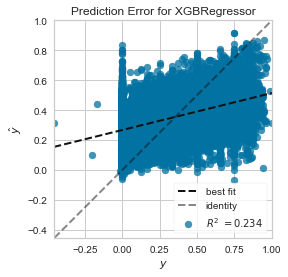

PredictionError(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7fa50b0048e0>,
                estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                       callbacks=None, colsample_bylevel=0.8,
                                       colsample_bynode=1, colsample_bytree=1,
                                       early_stopping_rounds=None,
                                       enable_categorical=False,
                                       eval_metric=None, feature_types=None,
                                       gamma=0, gpu_id=-1,
                                       grow_policy='depthwise',
                                       importance_type=None,
                                       interaction_constraints='',
                                       learning_rate=0.18, max_bin=256,
                                       max_cat_threshold=64,
                                       max_cat_to_onehot=4, max_delta_step=0,
              

In [85]:
# Making the Prediction Error Plot
print("\nPrediction Error Plot")
print(prediction_error(reg_mod, X_train, y_train, X_test, y_test))


Residuals Plot


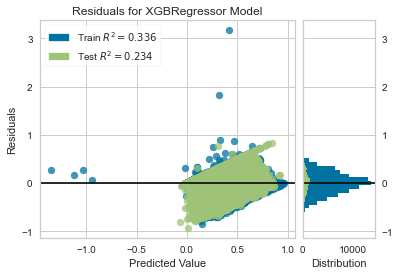

YellowbrickAttributeError: neither visualizer 'ResidualsPlot' nor wrapped estimator 'XGBRegressor' have attribute 'line_color'

In [86]:
# Making the Residuals Plot
print("\nResiduals Plot")
print(residuals_plot(reg_mod, X_train, y_train, X_test, y_test))

In [118]:
sku_with_big_discount_perc_cleaned_colorSize["prediction_discount_base"]= np.append(predictions_train_dt,predictions_dt)
sku_with_big_discount_perc_cleaned_colorSize["prediction_discount_final"]= np.append(predictions_train,predictions)

In [121]:
all_train, all_test = train_test_split(sku_with_big_discount_perc_cleaned_colorSize, test_size=0.2, random_state=123)

In [4]:
all_test

NameError: name 'all_test' is not defined

In [123]:
all_test.to_csv("sku_with_big_discount_perc_cleaned_colorSize_test_only.csv")